<a href="https://colab.research.google.com/github/JeFFich/Math_Programming/blob/main/%D0%98%D1%82%D0%BE%D0%B3%D0%BE%D0%B2%D0%BE%D0%B5_%D0%B7%D0%B0%D0%B4%D0%B0%D0%BD%D0%B8%D0%B5_%D0%9C%D0%A2%D0%A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sps

import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_white
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

In [ ]:
sns.set(style='darkgrid', palette='deep')
plt.rcParams['figure.figsize'] = 15, 9
plt.rcParams['savefig.format'] = 'pdf'

In [ ]:
# Источник: https://www.kaggle.com/datasets/nikhil7280/student-performance-multiple-linear-regression

df = pd.read_csv('/content/Student_Performance.csv')

df.head()

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
0,7,99,Yes,9,1,91.0
1,4,82,No,4,2,65.0
2,8,51,Yes,7,2,45.0
3,5,52,Yes,5,2,36.0
4,7,75,No,8,5,66.0


Описание колонок датасета, посвященной анализу успеваемости студентов:

1.   ```Hours Studied``` - кол-во часов, которые студент затратил на изучение предмета
2.   ```Previous Scores``` - предыдущие результаты ученика по тестам (*не до конца ясно, что подразумевал автор датасета под данным показателем, дополнительных разъяснений не приведено*)
3.   ```Extracurricular Activites``` - принимает ли студент участие во внеучебных активностях
4.   ```Sleep Hours``` - кол-во часов, которое в среднем спит студент
5.   ```Sample Question Papers Practiced``` - кол-во пробных тестов, написанных студентом
6.   ```Performance Index``` - некоторый показатель общей успеваемости студента (целевая переменная)


Сформулируем исходные задачи, которые мы преследуем при изучении данного датасета:


1.   ***Изучить влияние признаков на общую успеваемость, выделить наиболее значимые среди них; предложить ряд действий, способоных подтянуть эту успеваемость у наиболее отстающих студентов.***
2.   ***По исходным данным построить регрессионную моедль предсказания индекса общей успеваемости студента; проанализировать полученную модель с точки зрения объясняющей силы и выполнения ряда эконометрических предпосылок; попробовать построить альтернитувную модель на основе лишь наиболее сильных признаков и сопоставить ее с исходной.***


Каждый пункт рассмотрен в отдельной секции, в конце которых приводятся итоги по задаче (в силу относительной независимости задач логичнее показалось не смешивать итоги в отдельном блоке + проверять так кажется несколько проще)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Hours Studied                     10000 non-null  int64  
 1   Previous Scores                   10000 non-null  int64  
 2   Extracurricular Activities        10000 non-null  object 
 3   Sleep Hours                       10000 non-null  int64  
 4   Sample Question Papers Practiced  10000 non-null  int64  
 5   Performance Index                 10000 non-null  float64
dtypes: float64(1), int64(4), object(1)
memory usage: 468.9+ KB


Пропупущенных значений нет, 4 из 5 признаков - числовые, один - бинарный. Для более удобной работы переименуем колонки, зададим бинарные значения для 3 признака, а числовые - приведем к типу ```float```

In [ ]:
df.rename(columns={'Hours Studied':'stud_hour', 'Previous Scores': 'prev_scor', 'Extracurricular Activities':'extr_activ',
                   'Sleep Hours':'sleep_hour', 'Sample Question Papers Practiced': 'paper_pract', 'Performance Index': 'perf_ind'}, inplace=True)

In [ ]:
df[['stud_hour', 'prev_scor', 'sleep_hour', 'paper_pract']] = df[['stud_hour', 'prev_scor', 'sleep_hour', 'paper_pract']].astype(float)
df['extr_activ'] = df['extr_activ'].apply(lambda x: 1 if x == "Yes" else 0)

# Секция статистического анализа

Взглянем на распределение целевой переменной

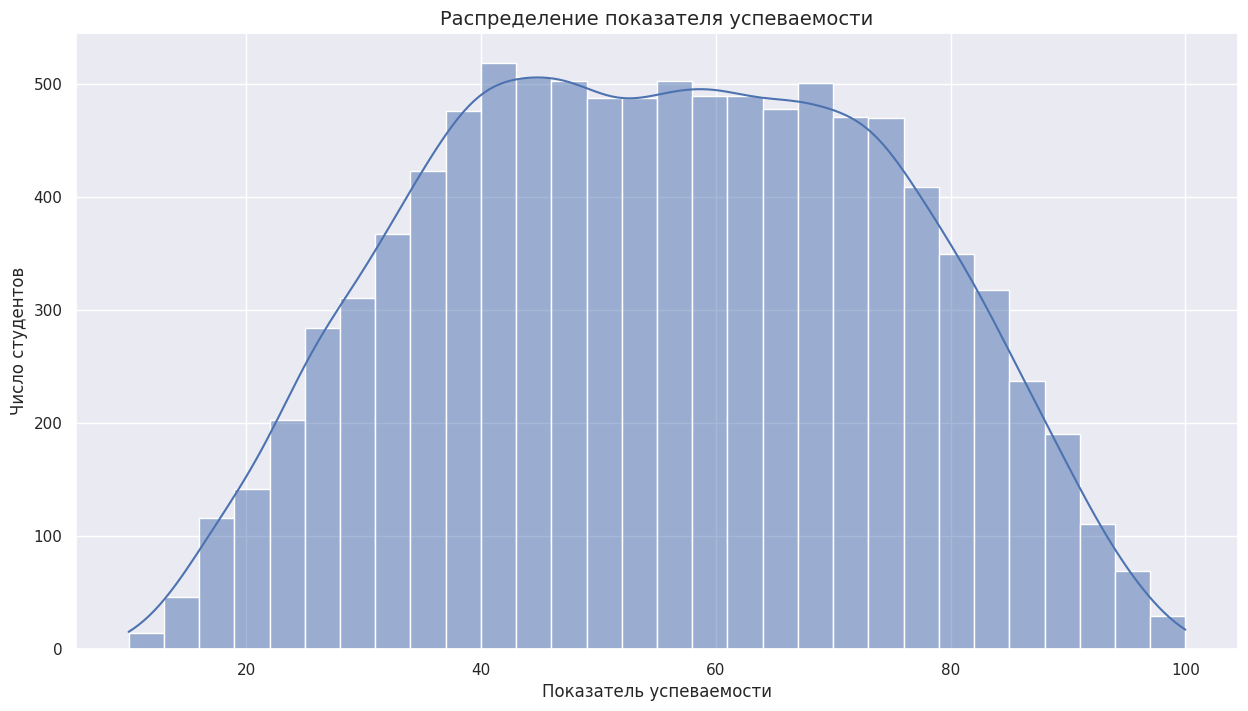

In [ ]:
plt.title('Распределение показателя успеваемости', fontsize=14)
sns.histplot(df['perf_ind'], bins=30, kde=True)
plt.xlabel("Показатель успеваемости")
plt.ylabel("Число студентов")

plt.show()

В целом распределение походит на нормальное, только пик получился более "сглаженным" (в результате общая фигура похожа на некоторую трапецию). Разобьем теперь всех студентов на три более-менее равные по численности целевые группы:


*  **Студенты с плохой успеваемостью** (показатель успеваемости *до 45*)
*  **Студенты со средней успеваемостью** (показатель успеваемости *от 45 до 65*)
*  **Студенты с хорошей успеваемостью** (показатель успеваемости *от 65*)



In [ ]:
bad_group = df[df['perf_ind'] < 45]
med_group = df[(df['perf_ind'] >= 45) & (df['perf_ind'] <= 65)]
good_group = df[df['perf_ind'] > 65]

In [ ]:
print("Численность первой группы - ", bad_group.shape[0])
print("Численность второй группы - ", med_group.shape[0])
print("Численность третьей группы - ", good_group.shape[0])

Численность первой группы -  3222
Численность второй группы -  3461
Численность третьей группы -  3317


## Анализ числовых признаков

Чтобы понять разницу в распределениях числовых признаков между группами, построим по каждому ящики с усами

In [ ]:
# Зададим доп столбец в исходном датасете, для более удобной визуализации (перед обучением модели удалим его)

df['group_id'] = 0
df.loc[bad_group.index, 'group_id'] = 1
df.loc[med_group.index, 'group_id'] = 2
df.loc[good_group.index, 'group_id'] = 3

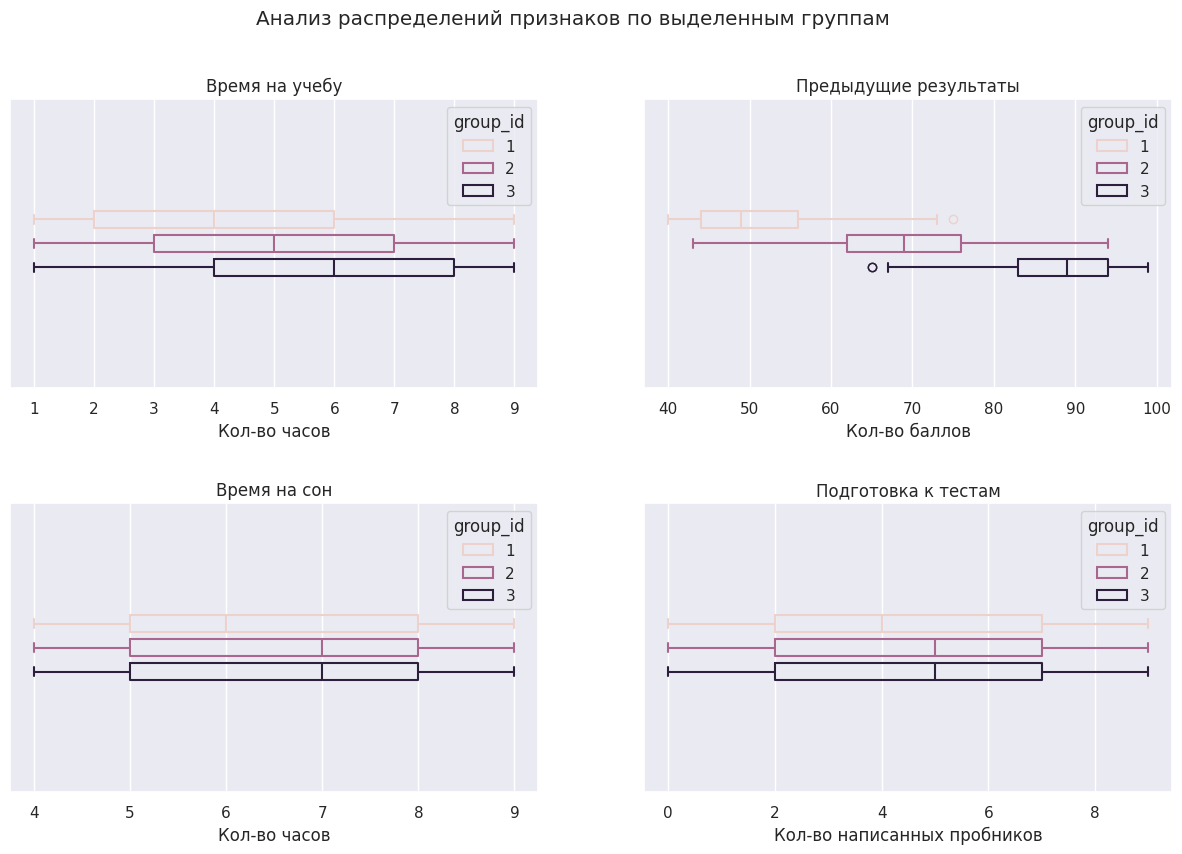

In [ ]:
plt.suptitle('Анализ распределений признаков по выделенным группам')

plt.subplots_adjust(hspace=0.4, wspace=0.2)

plt.subplot(2, 2, 1)
plt.title("Время на учебу", fontsize=12)
sns.boxplot(data = df, x='stud_hour', hue='group_id', width=0.25, orient='h', gap=0.3, fill=False)
plt.xlabel("Кол-во часов")

plt.subplot(2, 2, 2)
plt.title("Предыдущие результаты", fontsize=12)
sns.boxplot(data = df, x='prev_scor', hue='group_id', width=0.25, orient='h', gap=0.3, fill=False)
plt.xlabel("Кол-во баллов")

plt.subplot(2, 2, 3)
plt.title("Время на сон", fontsize=12)
sns.boxplot(data = df, x='sleep_hour', hue='group_id', width=0.25, orient='h', gap=0.3, fill=False)
plt.xlabel("Кол-во часов")

plt.subplot(2, 2, 4)
plt.title("Подготовка к тестам", fontsize=12)
sns.boxplot(data = df, x='paper_pract', hue='group_id', width=0.25, orient='h', gap=0.3, fill=False)
plt.xlabel("Кол-во написанных пробников")

plt.show()

Визуально хорошо заметно, что для первых двух признаков распределения по группам достаточно существенно различны, тогда как по другим признакам достаточно похожи (различны разве что медианы, и то только у первой группы). Проверим предположения при помощи **теста Манна-Уитни** по признакам и группам (здесь и далее для всех тестов будем использовать стандартный крит. уровень $\alpha = 0.05$)

In [ ]:
def whitney_res(x, y):
  p = sps.mannwhitneyu(x,y).pvalue
  return 'cтатистически значимых различий в распределении не выявлено' if p > 0.05 else 'выявлены статистически значимые различия в распределении'

In [ ]:
numeric_features = {'stud_hour':'Время на учебу', 'prev_scor':'Предыдущий результат', 'sleep_hour':'Время на сон', 'paper_pract':'Подготовка к тестам'}

for feature in numeric_features.keys():
  print(numeric_features[feature], '\n---')
  print('Группы №1 и №2: ', whitney_res(bad_group[feature], med_group[feature]))
  print('Группы №1 и №3: ', whitney_res(bad_group[feature], good_group[feature]))
  print('Группы №2 и №3: ', whitney_res(med_group[feature], good_group[feature]))
  print('---')

Время на учебу 
---
Группы №1 и №2:  выявлены статистически значимые различия в распределении
Группы №1 и №3:  выявлены статистически значимые различия в распределении
Группы №2 и №3:  выявлены статистически значимые различия в распределении
---
Предыдущий результат 
---
Группы №1 и №2:  выявлены статистически значимые различия в распределении
Группы №1 и №3:  выявлены статистически значимые различия в распределении
Группы №2 и №3:  выявлены статистически значимые различия в распределении
---
Время на сон 
---
Группы №1 и №2:  выявлены статистически значимые различия в распределении
Группы №1 и №3:  выявлены статистически значимые различия в распределении
Группы №2 и №3:  cтатистически значимых различий в распределении не выявлено
---
Подготовка к тестам 
---
Группы №1 и №2:  cтатистически значимых различий в распределении не выявлено
Группы №1 и №3:  выявлены статистически значимые различия в распределении
Группы №2 и №3:  выявлены статистически значимые различия в распределении
---


Полученный результат несколько отличается от ожидаемого по картинке: так ***отсутствие стат. значимых различий было выявлено лишь при 2 сравнениях из 12*** (причем на разных признаках); следовательно, все численные признаки несут некоторую информацию об особенностях группы.

Попробуем теперь проанализировать различия в средних значениях показателей различных групп (другими словами, оценим как отличаются средние представители каждой группы); для этого сделаем точечные оценки различий при помощи ***теста Стьюдента*** и интервальную при помощи ***бутстрапирования разницы средних***

In [ ]:
def t_res(x, y):
  p = sps.ttest_ind(x, y).pvalue
  return 'cтатистически значимых различий в средних не выявлено' if p > 0.05 else 'выявлены статистически значимые различия в средних'

def bootstrap_ci(x, y, n=3000):
  dist = []

  for _ in range(n):
    x_ex = np.random.choice(x, size=x.shape[0], replace=True)
    y_ex = np.random.choice(y, size=y.shape[0], replace=True)
    dist.append(x_ex.mean() - y_ex.mean())

  ci = np.percentile(dist, q=[2.5, 97.5])
  verd = 'гипотеза о равенстве средних не отклоняется' if (ci[0] < 0 and ci[1] > 0) else 'гипотеза о равенстве средних отклоняется'
  return np.round(ci,3), verd

def print_verd(x, y, n1, n2):
  t_test = t_res(x, y)
  bst_ci, bst_verd = bootstrap_ci(x,y)

  print(f"Группы №{n1} и №{n2}:")
  print("T-test: ", t_test)
  print(f"Эфронов интервал: {bst_ci};", " вывод по нему: ", bst_verd)

In [ ]:
for feature in numeric_features.keys():
  print(numeric_features[feature], '\n---')
  print_verd(bad_group[feature], med_group[feature], 1, 2)
  print_verd(bad_group[feature], good_group[feature], 1, 3)
  print_verd(med_group[feature], good_group[feature], 2, 3)
  print('---')

Время на учебу 
---
Группы №1 и №2:
T-test:  выявлены статистически значимые различия в средних
Эфронов интервал: [-1.109 -0.873];  вывод по нему:  гипотеза о равенстве средних отклоняется
Группы №1 и №3:
T-test:  выявлены статистически значимые различия в средних
Эфронов интервал: [-1.972 -1.734];  вывод по нему:  гипотеза о равенстве средних отклоняется
Группы №2 и №3:
T-test:  выявлены статистически значимые различия в средних
Эфронов интервал: [-0.982 -0.744];  вывод по нему:  гипотеза о равенстве средних отклоняется
---
Предыдущий результат 
---
Группы №1 и №2:
T-test:  выявлены статистически значимые различия в средних
Эфронов интервал: [-18.719 -17.853];  вывод по нему:  гипотеза о равенстве средних отклоняется
Группы №1 и №3:
T-test:  выявлены статистически значимые различия в средних
Эфронов интервал: [-37.852 -37.088];  вывод по нему:  гипотеза о равенстве средних отклоняется
Группы №2 и №3:
T-test:  выявлены статистически значимые различия в средних
Эфронов интервал: [-19.59

В принципе, мы получили примерно тот же результат, что и при сопоставлении распределений: ***только для 2 из 12 пар не было выявлено статистически значимое различие в средних показателях признаков в группе*** (*пары те же самые, что и для распределений*).

Изучим теперь коррелированность анализируемых признаков с целевой переменной. Сперва визуализируем совместное распределение с помощью точечной диаграммы

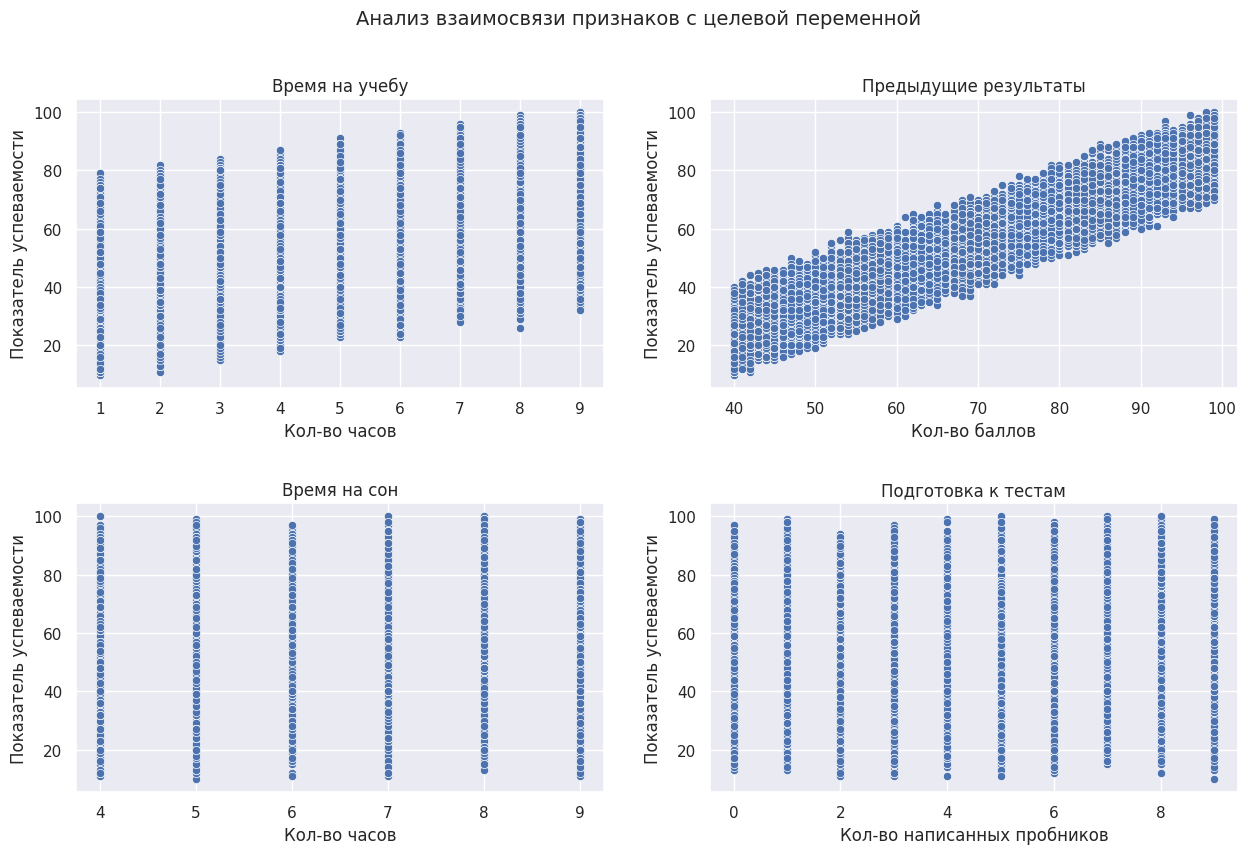

In [ ]:
plt.suptitle('Анализ взаимосвязи признаков с целевой переменной', fontsize=14)

plt.subplots_adjust(hspace=0.4, wspace=0.2)

plt.subplot(2, 2, 1)
plt.title("Время на учебу", fontsize=12)
sns.scatterplot(data = df, x='stud_hour', y='perf_ind')
plt.xlabel("Кол-во часов")
plt.ylabel("Показатель успеваемости")

plt.subplot(2, 2, 2)
plt.title("Предыдущие результаты", fontsize=12)
sns.scatterplot(data = df, x='prev_scor', y='perf_ind')
plt.xlabel("Кол-во баллов")
plt.ylabel("Показатель успеваемости")

plt.subplot(2, 2, 3)
plt.title("Время на сон", fontsize=12)
sns.scatterplot(data = df, x='sleep_hour', y='perf_ind')
plt.xlabel("Кол-во часов")
plt.ylabel("Показатель успеваемости")

plt.subplot(2, 2, 4)
plt.title("Подготовка к тестам", fontsize=12)
sns.scatterplot(data = df, x='paper_pract', y='perf_ind')
plt.xlabel("Кол-во написанных пробников")
plt.ylabel("Показатель успеваемости")

plt.show()

По полученным диаграммам явно **заметна сильная прямая связь второго признака с целевой переменной**; некоторое **подобие линейной зависимости прослеживается и у первого признака**. **Остальные два не выявляют наличие закономерностей** в совместных распределениях.

Проверим эти предположения, рассчитав ***коэффициент корреляции Пирсона*** для каждого признака и проверив их значимость с помощью ***критерия Пирсона***

In [ ]:
def pearson_res(x, y):
  r, p = sps.pearsonr(x, y)
  verd = 'коэффициент корреляции значим' if p < 0.05 else 'коэффициент корреляции незначим'

  return r, verd

In [ ]:
for feature in numeric_features.keys():
  r, verd = pearson_res(df[feature], df['perf_ind'])

  print(numeric_features[feature])
  print(f"Коэффициент корреляции: {r:.3f};", " вывод по нему: ", verd)
  print('---')

Время на учебу
Коэффициент корреляции: 0.374;  вывод по нему:  коэффициент корреляции значим
---
Предыдущий результат
Коэффициент корреляции: 0.915;  вывод по нему:  коэффициент корреляции значим
---
Время на сон
Коэффициент корреляции: 0.048;  вывод по нему:  коэффициент корреляции значим
---
Подготовка к тестам
Коэффициент корреляции: 0.043;  вывод по нему:  коэффициент корреляции значим
---


В данном случае, мы просто численно подтвердили ранее замечанные на графиках зависимости.

## Анализ категориального признака

Сперва взглянем на распределение бинарного признака по выделенным группам

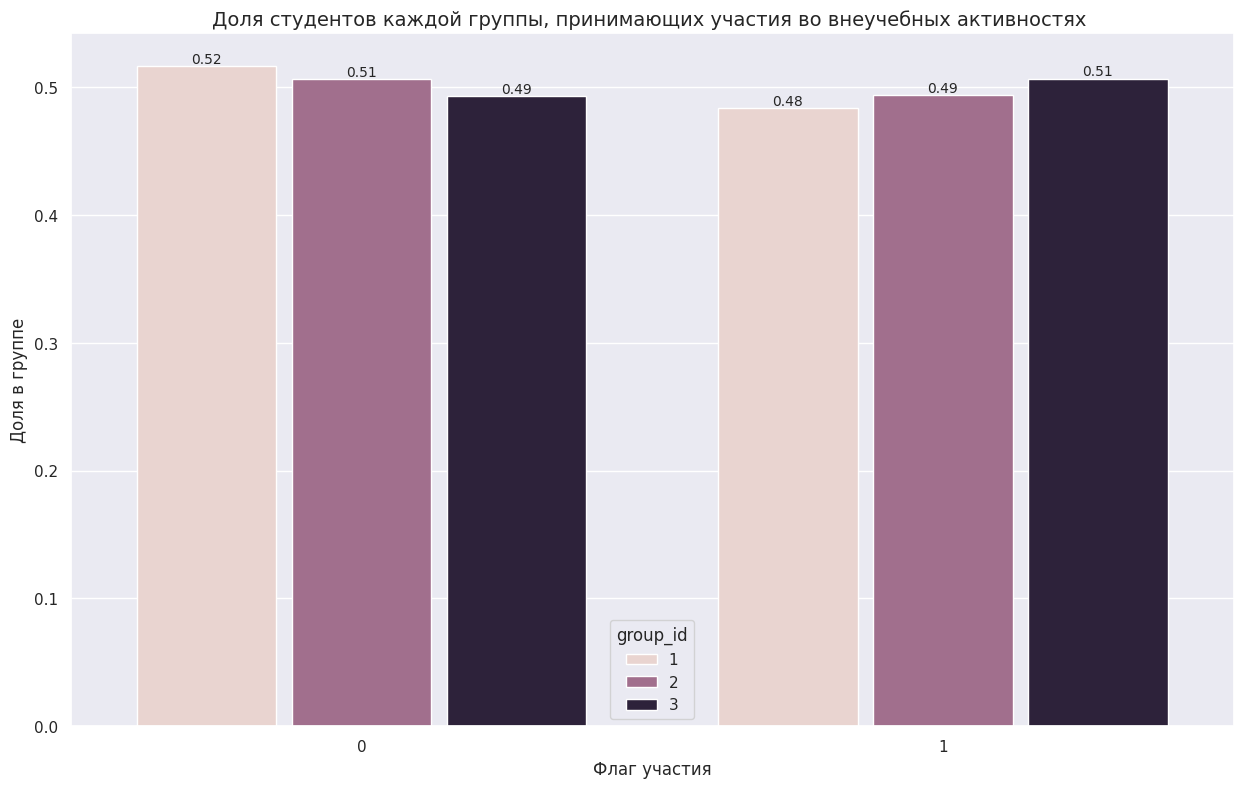

In [ ]:
data = pd.DataFrame(df.groupby(by=['group_id'])['extr_activ'].value_counts(normalize=True))
data.rename(columns={'extr_activ':'Count'},inplace=True)

plt.title('Доля студентов каждой группы, принимающих участия во внеучебных активностях ', fontsize=14)
ax = sns.barplot(data.reset_index(), x="extr_activ", y="Count", hue="group_id", gap=0.1)

for i in range(3):
  ax.bar_label(ax.containers[i], fontsize=10, fmt='%0.2f')

plt.xlabel('Флаг участия')
plt.ylabel('Доля в группе')

plt.show()

По графику видно, что ***распределения признака по группам не сильно различается***. Проверим это предположение с помощью ***критерия хи-квадрат***

In [ ]:
def chi_test(x, y):
  p = sps.chisquare(x, y).pvalue
  return 'cтатистически значимых различий в распределении не выявлено' if p > 0.05 else 'выявлены статистически значимые различия в распределении'

In [ ]:
# Получим распределения признака по группам
data = data.reset_index().sort_values(by=['group_id', 'extr_activ'])['Count'].values.reshape(3,2)
x_1 = data[0, :]
x_2 = data[1, :]
x_3 = data[2, :]

print("Группы №1 и №2: ", chi_test(x_1, x_2))
print("Группы №1 и №3: ", chi_test(x_1, x_3))
print("Группы №2 и №3: ", chi_test(x_2, x_3))

Группы №1 и №2:  cтатистически значимых различий в распределении не выявлено
Группы №1 и №3:  cтатистически значимых различий в распределении не выявлено
Группы №2 и №3:  cтатистически значимых различий в распределении не выявлено


Хи-квадрат так же **подтвердил отсутствие статистически значимых различий в распределении значений бинарного признака по группам**. Следовательно, **признак не несет в себе особо ценной информации о различии групп** (что важно с точки зрения выработки продуктовых гипотез и предложений по улучшению целевого показателя в отстающей группе)

Убедимся в слабой информативности признака в целом, рассмотрев его коррелированность с целевой переменной; так как показатель бинарной, то лучше будет ***вычислять и проверять значимость коэффициента Спирмана/Кендалла*** (здесь посмотрим на оба)

In [ ]:
# коэффициент Спирмана
sps.spearmanr(df['extr_activ'], df['perf_ind'])

SignificanceResult(statistic=0.021914836618398787, pvalue=0.02841759099093625)

In [ ]:
# коэффициент Кендалла
sps.kendalltau(df['extr_activ'], df['perf_ind'])

SignificanceResult(statistic=0.01801886972139276, pvalue=0.028424732869425078)

В обоих случаях мы получили p-уровень ниже стандартного уровня значимости, следовательно можем констатировать **статистическую незначимость связи между целевым показателем и рассматриваемым бинарным признаком**

## Итоги и выводы по секции статистического анализа

Обобщим проведенный выше анализ, зафиксировав основные результаты:

1.   Распределение признаков по группам:


*   **Наибольший вклад в формирование "профиля" группы делают признаки, напрямую свзяанные с учебой - кол-во часов, затраченных на изучение и результаты по тестам**: в каждой группе средние показатели и распределения в общем существенно отличаются. С точки зрения улучшения результатов наиболее отстающих студентов, именно на эти показатели стоит обращать внимание в первую очередь
*   **Несколько меньший вклад имеют показатели часов сна и число написанных пробных тестов**: у соседних групп средние могут различаться незначительно, как и распределения. С точки зрения улучшения результатов наиболее отстающих студентов, переоценивать важность данных показателей не стоит (можно пожертвовать в угоду показателям, упомянутым выше)
*   Наконец, **единственный категориальный признак**, как оказалось, **практически не участвует в формировании "профиля" группы**. С точки зрения улучшения результатов наиболее отстающих студентов, на нем можно даже не акцентировать свое внимание


2.   Влияние признаков на целевую переменную:

* **Наиболее сильное влияние снова было выявлено у первых двух признаков**: коэффициенты корреляции здесь получились наибольшие. Опять же, это дополнительно подтверждает их ценности для проработки отстающих студентов
*  **Небольшой вклад оказывают другие численные факторы**: хотя коэффициенты корреляции получились значимыми, по абсолютной величине они достаточно невелики. Поэтому, работа над этими показателями может иметь некоторый положительный эффект у отстающих студентов, размер этого эффекта будет крайне незначительным
*  **Категориальный признак вновь не продемонстрировал какого-либо влияния на целевой показатель**: коэффициент корреляции получился попросту статистически незначимым. Как итого, очередное подтверждение неактульности работы над улучшениями показателя ради улучшения результатов отстающих студентов




Исходя из написанного выше, попробуем предложить ряд методов, направленных на улучшение показателей наиболее важных признаков с точки зрения целевой переменной:


*   **Внедрить новые методики преподавания материала**. Плохие результаты тестов могут быть вызваны устаревшими подходами к обучению, что затрудняют усваивание материала обучающимися; как итог, многие перестают быть заинтересованными в учебе, что явно негативно сказывается и на кол-во часов, которые они готовы тратить на обучение, и на конечные знания, из-за чего результаты тестов крайне низки. Применение более успешных и современных методик в процесс обучения может существенно повысить заинтересованность обучающихся, и, как следствие, решить проблемы с успеваемостью
*   **Пересмотреть методологию подсчета общей успешности ученика**. На текущий момент наблюдается крайне серьёзный перекос в сторону всего лишь одного показателя, что не кажется чересчур обоснованным. Например, кажется разумным учитывать участие студента во внешкольной активности в большей степени чем это есть на данный момент (вернее нет совсем)



In [ ]:
# Удалим ненужную колонку
df.drop(columns=['group_id'], inplace=True)

# Секция регрессионного анализа

## Базовая модель

Для начала, обучим модель на всех признаках и выведем отчет

In [ ]:
X = sm.add_constant(df.drop(columns=['perf_ind']))
base_model = sm.OLS(df['perf_ind'], X).fit()

In [ ]:
print(base_model.summary())

                            OLS Regression Results                            
Dep. Variable:               perf_ind   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                 1.757e+05
Date:                Mon, 18 Mar 2024   Prob (F-statistic):               0.00
Time:                        18:02:11   Log-Likelihood:                -21307.
No. Observations:               10000   AIC:                         4.263e+04
Df Residuals:                    9994   BIC:                         4.267e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const         -34.0756      0.127   -268.010      

По результатам обучения модели можно сделать следующие выводы:



1.   $R^2$ получился **крайне большим**, **практически равным единице**; на реальных данных это было бы ***несомненным сигналом о наличие у полученной модели выдающихся способностей к переобучению***, но в данном случае это говорит лишь об ***удачно выбранной спецификации модели***
2.   **Все коэффициенты регрессии получились статистически значимыми**, само **уравнение - тоже значимо**; **доверительные интервалы у оценок достаточно небольшие**, что говорит об ***устойчивости модели к шумам в данных***
3.   **Абсолютные величины коэффициентов у регрессоров показывают значительную зависимость целевой переменной от всего лишь двух показателей**: *кол-во часов изучения и предыдущие результаты*; напомним, что характер этой свзяи был подмечен еще в предыдущей секции



## Выполнение предпосылок

Проверим теперь выполнение ряда эконометрических предпосылок у модели. Сперва взглянем на распределение остатков

In [ ]:
# Запомним предикты и остатки
df['predict'] = base_model.predict(X)
df['residuals'] = base_model.resid

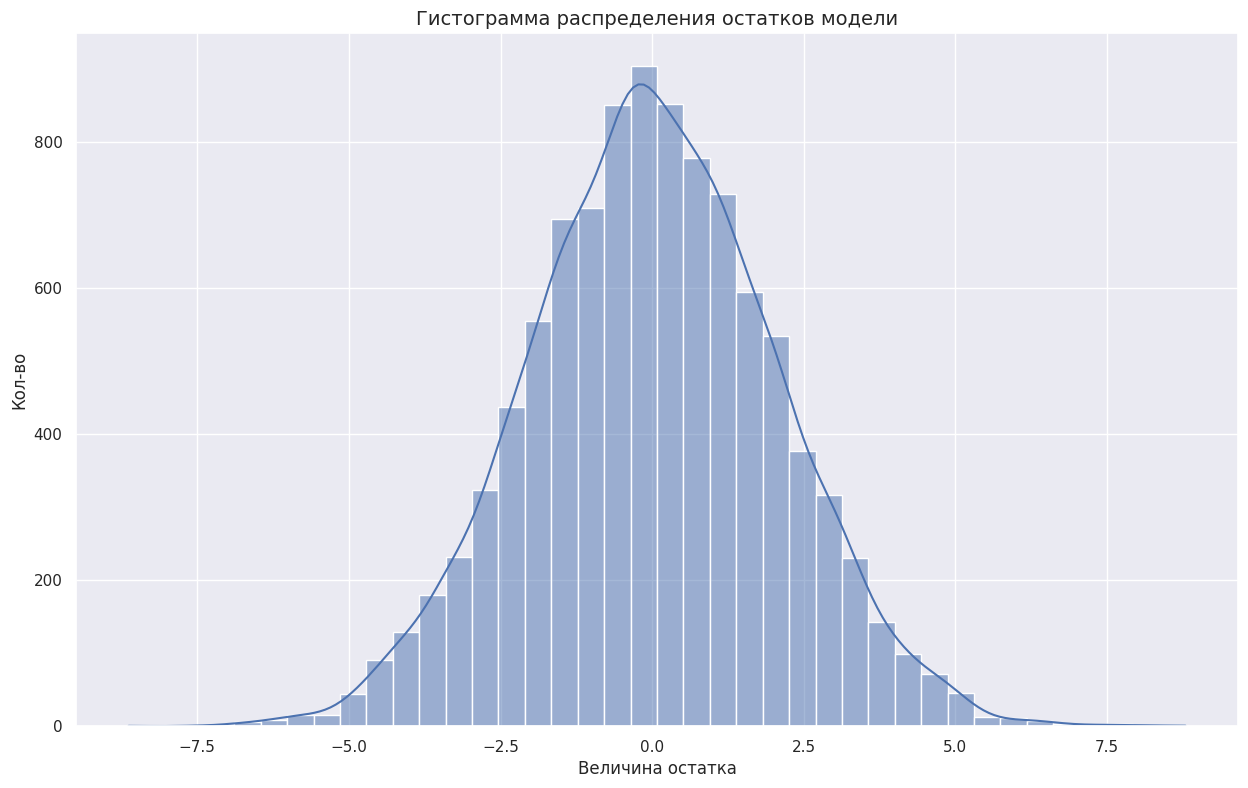

In [ ]:
plt.title('Гистограмма распределения остатков модели', fontsize=14)
sns.histplot(df['residuals'], bins=40, kde=True)
plt.xlabel("Величина остатка")
plt.ylabel("Кол-во")

plt.show()

По гистограмме можно сделать ***предположение о нормальном распределении остатков***; проверим эту гипотезу с помощью *трех статистических тестов на нормальность*

In [ ]:
def normal_check(test_res):
  p = test_res.pvalue
  return "распределение нормальное" if p >= 0.05 else "распределение отличается от нормального"

print("Тест Колмогорова-Смирнова:", normal_check(sps.kstest(df['residuals'], 'norm')))
print("Тест Харке-Бера:", normal_check(sps.jarque_bera(df['residuals'])))
print("Тест Д'Агостина:", normal_check(sps.normaltest(df['residuals'])))

Тест Колмогорова-Смирнова: распределение отличается от нормального
Тест Харке-Бера: распределение нормальное
Тест Д'Агостина: распределение нормальное


***Два из трех тестов дали утвердительный ответ***, так что можно **принять нулевую гипотезу о нормальности распределения остатков**.

Далее, визуализируем точечное распределение остатков у каждого предсказания по отношению к среднему; это поможет сделать предположение о выполнении предпосылки гомоскедастичности в модели

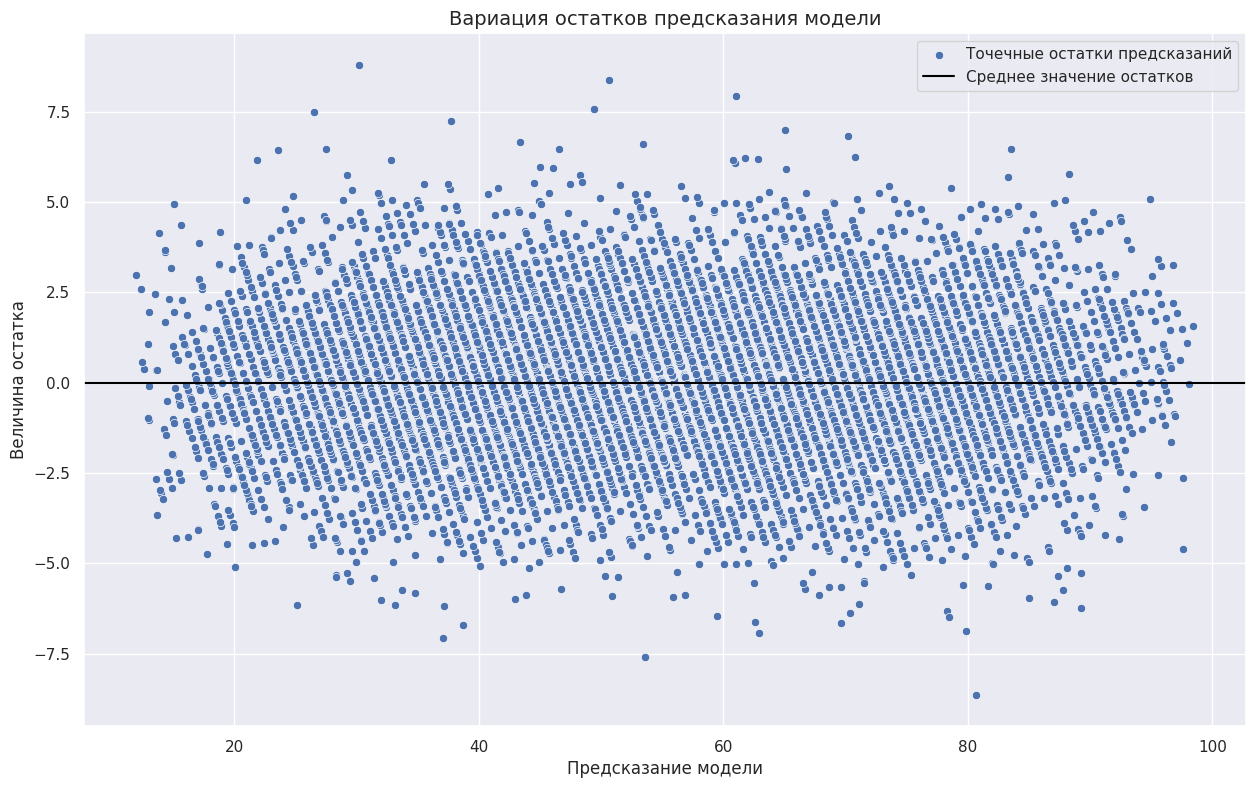

In [ ]:
plt.title("Вариация остатков предсказания модели", fontsize=14)
resid_distr = sns.scatterplot(data=df, x='predict', y='residuals', label='Точечные остатки предсказаний')
resid_distr.axhline(df['residuals'].mean(), color='black', label='Среднее значение остатков')
plt.xlabel("Предсказание модели")
plt.ylabel("Величина остатка")
plt.legend()

plt.show()

По диаграмме видно, что ***дисперсия остатков носит в целом постоянный характер***, так что кажется, что **гомоскедастичность имеется**; убедимся в этом при помощи *теста Вайта*

In [ ]:
het_white(base_model.resid, base_model.model.exog)[1]

0.6989279983086665

Полученный ***p-уровень больше критического***, следовательно **гипотезу о гомоскедастичности мы принимаем**.

Остается проверить наличие мультиколлинеарности в данных. Для этого сперва выведем тепловую карту с парными коэффициентами корреляции

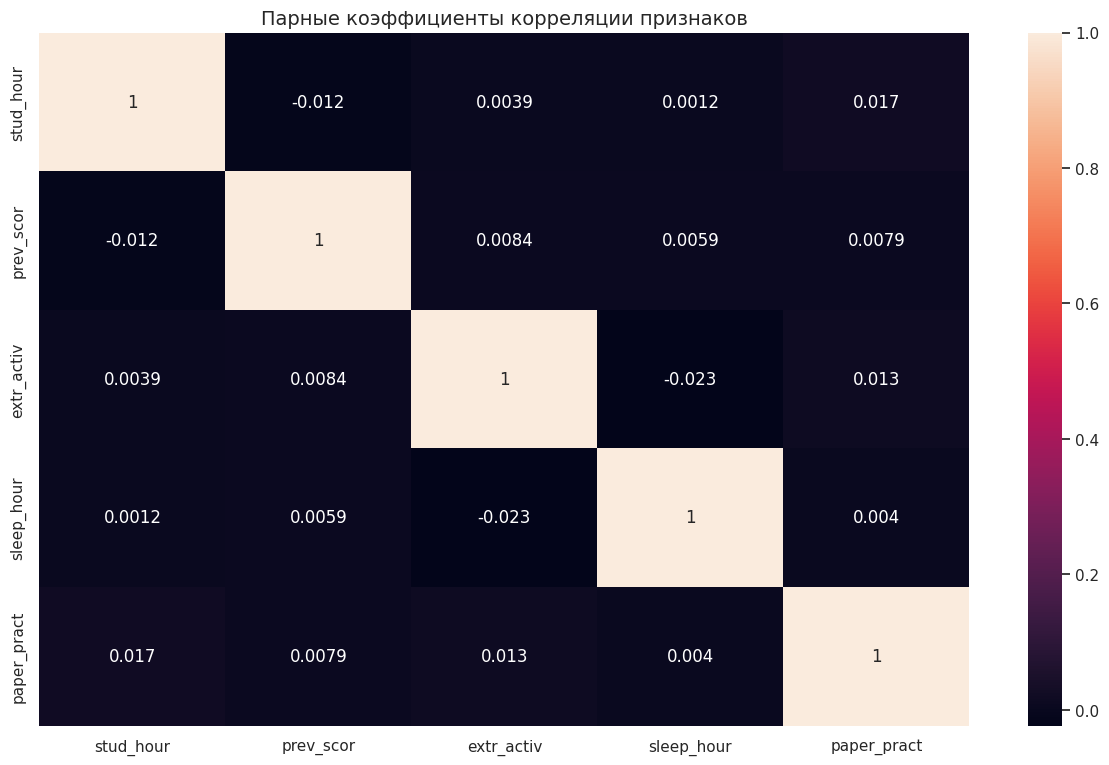

In [ ]:
plt.title("Парные коэффициенты корреляции признаков", fontsize=14)
sns.heatmap(data=df.drop(columns=['perf_ind', 'predict', 'residuals']).corr(), annot=True)

plt.show()

Можно заметить, что ***абсолютные величины коэффициентов регрессии пренебрежимо малы***, что практически подтверждает **отсутствие сильной корреляции между признаками**; чтобы окончательно убедиться в этом, рассчитаем для каждого признака *фактор инфляции дисперсии*

In [ ]:
VIFs = pd.Series(
        [vif(X.values, i) for i in range(X.shape[1])],
        index=X.columns)[1:]

# Создадим и покажем датафрейм с VIF значениями
dt = pd.DataFrame(VIFs).reset_index()
dt.columns = ['Feature', 'VIF']

dt

,Feature,VIF
0,stud_hour,1.000478
1,prev_scor,1.000326
2,extr_activ,1.000802
3,sleep_hour,1.000600
4,paper_pract,1.000557


Все ***значения VIF получились примерно 1***, что говорит о **полном отсутствии мультиколлинеарности**.

## А что если уменьшить число признаков?

Напоследок изучим, **насколько ухудшилась бы наша модель при обучении ее только на первых двух, наиболее сильных признаках**

In [ ]:
X_0 = sm.add_constant(df[['stud_hour', 'prev_scor']])
strong_only_model = sm.OLS(df['perf_ind'], X_0).fit()

print(strong_only_model.summary())

                            OLS Regression Results                            
Dep. Variable:               perf_ind   R-squared:                       0.986
Model:                            OLS   Adj. R-squared:                  0.986
Method:                 Least Squares   F-statistic:                 3.488e+05
Date:                Mon, 18 Mar 2024   Prob (F-statistic):               0.00
Time:                        19:41:21   Log-Likelihood:                -22446.
No. Observations:               10000   AIC:                         4.490e+04
Df Residuals:                    9997   BIC:                         4.492e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -29.8168      0.105   -285.248      0.0

Как можно заметить, у новой модели ***несколько возросли информационные показатели AIC и BIC***, что говорит о **потери части информации о распределении целевой переменной при исключении 3 слабых признаков**; тем не менее, ***коэффициент детерминации практически не изменился***; это значит, что **вторая модель практически не уступает первой с точки зрения описания и прогнозирования, занимая при этом меньший объём по памяти**. Поэтому, на мой взгляд, именно *вторая модель была бы более предпочтительной*, так как требовала бы куда *меньше данных для обучения и предсказания*, при результате не сильно хуже

## Итоги по секции регрессионного анализа

Обобщим проведенный выше регрессионный анализ, зафиксировав основные результаты


1.   **Базовая модель**, построенная на всех пяти признаках, **оказалась крайне успешной** (скорее подозрительно успешной) для описания поведения целевой переменной;
2.   Помимо этого, **модель удовлетворяет всем предпосылкам КНЛМ** (Гаусс-Марков + предпосылка о нормальности), а значит ***полученные оценки являются оптимальными среди всех несмещенных оценок параметров истинной регрессии***;
3.   **В качестве альтерантивы** базовой модели **можно рассматривать регрессию, построенную лишь на 2 из 5 признаках** (показавших наибольшую связь с целевой переменной). При таком подходе ***незначительное ухудшение итогового качества приносится в жертву значительному сокращению требований к данным***.

